In [71]:
# Install the search engine
!pip install langchain-tavily dotenv langgraph langchain "langchain[ollama]" IPython

In [72]:
#  configure the environment
from dotenv import load_dotenv
load_dotenv()

from langchain_tavily import TavilySearch

# define the tool
tool = TavilySearch(max_results = 2)
tools = [tool]
#tool.invoke("What is a node in langgraph?")

In [73]:
import os
from langchain.chat_models import init_chat_model

llm = init_chat_model('ollama:llama3.2')
llm_with_tools = llm.bind_tools(tools=tools)

In [74]:
# defining the graph

from typing import Annotated, Sequence, TypedDict
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, START, END
from pprint import pprint


# defining the state 
class AgentState(TypedDict):
    messages: Annotated[Sequence, add_messages]


def chatbot(state: AgentState) -> AgentState:
    response = llm_with_tools.invoke(state.get('messages'))
    pprint(response)
    return {"messages": [response]}

graph_builder = StateGraph(AgentState)
graph_builder.add_node("chatbot", chatbot)

graph_builder.add_edge(START, "chatbot")


In [75]:
# create a function to runt the tools (Tool Node function)

import json
from langchain_core.messages import ToolMessage

class BasicToolNode:
    """
    A node that runs the tools required in the last AIMessage
    """

    def __init__(self, tools: list) -> None:
        self.tool_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        # if messages are present then get the last tool message

        if messages := inputs.get("messages", []) :
            message = messages[-1]
        else:
            raise ValueError('No Message found in input')
        

        outputs = []

        # loop over the tool calls and invoke the tool to get the response
        for tool_call in message.tool_calls:
            tool_result = self.tool_by_name[tool_call.get('name')].invoke(
                tool_call.get('args')
            )

            # append the tool response to outputs list
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call.get('name'),
                    tool_call_id = tool_call['id']
                )
            )
        

        # return the updated state
        return {"messages": outputs}

tool_node = BasicToolNode(tools=tools)

# add the tool node to the graph
graph_builder.add_node("tools",tool_node )

In [76]:
# define the conditional edge for the graph

def route_tools(state: AgentState):
    """
    Use in the graph conditional edge, to route to ToolNode if the last message have tool calls, otherwise route to end node
    """

    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No message found in input state to tools_edge: {state}")
    
 
    # check whether the message have tool_calls attribute
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    
    return END


# adding conditional edge to the graph
graph_builder.add_conditional_edges(
    source="chatbot",
    path=route_tools,
    path_map={
        "tools": "tools",
        END: END
    }
)

# adding the edge from tools to chatbot
graph_builder.add_edge("tools","chatbot")

# compiling the graph
graph = graph_builder.compile()



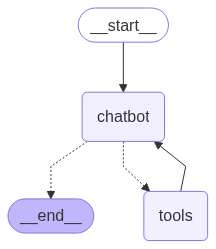

In [77]:
# dispalaying the graph 

from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [78]:
# ask the chatbot the questions
from pprint import pprint

def stream_graph_updates(user_input: str)->None:
    initial_state = {"messages":[{"role": "user","content": user_input}]}
    for event in graph.stream(initial_state):
        #pprint(event)
        for value in event.values():
            print("\nAssistent: ", value.get('messages')[-1].content)


while True:
    try:
        user_input = input("\nUser: ").strip()

        if user_input.lower() in ['q', 'exit', 'quit']:
            print("\nGood Bye!!!")
            break

        stream_graph_updates(user_input=user_input)
    except Exception as e:
        user_input = "What do you know about LangGraph?"
        print("User: ", user_input)
        stream_graph_updates(user_input=user_input)
        break

AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'llama3.2', 'created_at': '2025-06-13T01:10:57.039805Z', 'done': True, 'done_reason': 'stop', 'total_duration': 5524330500, 'load_duration': 41460083, 'prompt_eval_count': 964, 'prompt_eval_duration': 3383553250, 'eval_count': 67, 'eval_duration': 2096142625, 'model_name': 'llama3.2'}, id='run--d00facc9-38f2-475f-b34a-e3009d255540-0', tool_calls=[{'name': 'tavily_search', 'args': {'exclude_domains': None, 'include_domains': None, 'include_images': False, 'query': 'StateGraph in LangGraph and its usefulness for building AI Agents', 'search_depth': 'advanced', 'time_range': None, 'topic': 'general'}, 'id': '3ca2497d-f074-4183-a98d-c2fb08b69037', 'type': 'tool_call'}], usage_metadata={'input_tokens': 964, 'output_tokens': 67, 'total_tokens': 1031})

Assistent:  

Assistent:  {"query": "StateGraph in LangGraph and its usefulness for building AI Agents", "follow_up_questions": null, "answer": null, "images": [], "result